# OpenPrefEval: Dead Simple Open LLM Evaluation

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# !pip install peft bitsandbytes -q
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from open_pref_eval.datasets import get_default_datasets
from open_pref_eval.evaluation import evaluate_models, evaluate_model, evaluate
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
datasets = get_default_datasets(100)
datasets

[Dataset({
     features: ['prompt', 'chosen', 'rejected', 'id'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 })]

In [4]:

# 
from peft import AutoPeftModelForCausalLM, get_peft_model, PeftConfig, PeftModelForCausalLM
import torch
from transformers import BitsAndBytesConfig
from open_pref_eval.plot.radar import radar_plot
model_name = "markab/Qwen1.5-Capybara-0.5B-Chat" # quick no diff
model_name = "Rustamshry/Qwen3-0.6B-OpenMathReason"


model_name = "wassname/qwen-7B-codefourchan-QLoRA"
# model_name = "wassname/qwen-14B-codefourchan-QLoRA"

# model_name = "alignment-handbook/zephyr-7b-sft-qlora"
# model_name = "gepardzik/LLama-3-8b-rogue-lora" # small diff

quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

### Load method 1 a huggingface model with PeftMixin
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", 
    torch_dtype=torch.bfloat16, 
    quantization_config=quantization_config
)
# model.load_adapter(model_name)
# print(model.peft_config)
# model.delete_adapter('default')
# model.load_adapter(model_name)
# print(model.peft_config)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:

# # ## Load method 2 a PeftModel
# model = PeftModelForCausalLM.from_pretrained(
#     model,
#     model_name,
#     device_map="auto",
#     torch_dtype=torch.bfloat16,
#     quantization_config=quantization_config,
# )
# print(model.peft_config)

In [6]:

tokenizer = AutoTokenizer.from_pretrained(model.peft_config['default'].base_model_name_or_path)

In [7]:
# model.delete_adapter('default')
# model.load_adapter(model_name, '4chan')

In [8]:
print(model.peft_config)

{'default': LoraConfig(task_type='CAUSAL_LM', peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='unsloth/Qwen2.5-Coder-7B-Instruct', revision=None, inference_mode=True, r=64, target_modules={'o_proj', 'gate_proj', 'k_proj', 'v_proj', 'q_proj', 'up_proj', 'down_proj'}, exclude_modules=None, lora_alpha=64, lora_dropout=0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False)}


In [9]:
import numpy as np
from functools import partial
import numpy as np
import pandas as pd

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [ ]:
from open_pref_eval.scoring import first_nonzero, score_1st_diverg, score_preferences, score_ipo, score_cumsum, score_weighted, score_weighted_prob, score_with_weight, score_f_alpha_divergance, score_f_divergance, score_agg, score_certainty_weighted, score_entropy_weighted, score_power_mean, score_with_decay, score_percentile, score_1st_diverg, score_perplexity_ratio
score_fns = {
    "preferences": score_preferences,
    "cumsum": score_cumsum,
    "weighted": score_weighted, # littlediff
    # "weighted_prob": score_weighted_prob, # nan
    "with_weight": score_with_weight,
    "f_alpha_divergance": score_f_alpha_divergance,
    "f_divergance": score_f_divergance,
    # "min": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.min(x, dim=-1).values),
    # "max": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.max(x, dim=-1).values),
    # "mean": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.mean(x, dim=-1)),
    # "median": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.median(x, dim=-1).values),
    # "std": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.std(x, dim=-1)),
    "ipo": score_ipo,
    "entropy_weighted": score_entropy_weighted,
    "certainty_weighted": score_certainty_weighted,
    "power_mean": score_power_mean,
    "with_decay": score_with_decay,
    "percentile": score_percentile,
    "1st_diverg": score_1st_diverg,
    "perplexity_ratio": score_perplexity_ratio,

}


In [11]:
results, df_raw1 = evaluate_model(
    model=model,
    tokenizer=tokenizer,
    datasets=datasets,
    batch_size=6,
    max_length=1024,
    max_prompt_length=512,
    verbose=2,
    score_fn=score_fns
) 
# results

  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
2025-05-23 19:54:45.767 | DEBUG    | open_pref_eval.evaluation:eval_dataset:184 - Detected adapters: [None, 'default']
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/transformers/integrations/peft.py:443: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval imdb_preferences-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

2025-05-23 19:55:34.427 | DEBUG    | open_pref_eval.evaluation:eval_dataset:184 - Detected adapters: [None, 'default']
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/transformers/integrations/peft.py:443: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-23 19:55:39.271 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-23 19:55:43.247 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 33.33%

Eval truthful_qa_preferences-validation[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

2025-05-23 19:56:18.817 | DEBUG    | open_pref_eval.evaluation:eval_dataset:184 - Detected adapters: [None, 'default']
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/transformers/integrations/peft.py:443: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval mmlu_preferences-elementary_mathematics-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

2025-05-23 19:56:25.001 | DEBUG    | open_pref_eval.evaluation:eval_dataset:184 - Detected adapters: [None, 'default']
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/transformers/integrations/peft.py:443: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-commonsense-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

2025-05-23 19:56:33.146 | DEBUG    | open_pref_eval.evaluation:eval_dataset:184 - Detected adapters: [None, 'default']
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/transformers/integrations/peft.py:443: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-utilitarianism-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

2025-05-23 19:56:38.597 | DEBUG    | open_pref_eval.evaluation:eval_dataset:184 - Detected adapters: [None, 'default']
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/transformers/integrations/peft.py:443: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-justice-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

2025-05-23 19:56:44.821 | DEBUG    | open_pref_eval.evaluation:eval_dataset:184 - Detected adapters: [None, 'default']
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/transformers/integrations/peft.py:443: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-deontology-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

2025-05-23 19:56:51.095 | DEBUG    | open_pref_eval.evaluation:eval_dataset:184 - Detected adapters: [None, 'default']
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/transformers/integrations/peft.py:443: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [12]:
model_id = 'snake7gun/tiny-random-qwen3'
model2 = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto",
    torch_dtype=torch.bfloat16, 
    quantization_config=quantization_config
)
tokenizer2 = AutoTokenizer.from_pretrained(model_id)

In [13]:
results2, df_raw2 = evaluate_model(
    model=model2,
    tokenizer=tokenizer2,
    datasets=datasets,
    batch_size=6,
    max_length=1024,
    max_prompt_length=512,
    verbose=2,
    score_fn=score_fns
) 
# results
df_raw2['adapter'] = model_id


  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval imdb_preferences-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-23 19:56:59.678 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-23 19:56:59.729 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 33.33% of samples. Consider increasing max_prompt_length.
2025-05-23 19:56:59.847 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-23 19:56:59.926 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of sa

Eval truthful_qa_preferences-validation[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval mmlu_preferences-elementary_mathematics-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-commonsense-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-utilitarianism-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-justice-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-deontology-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [14]:
df_raw = pd.concat([df_raw1, df_raw2], axis=0)

In [15]:
df_raw.fillna({'adapter': 'base'}, inplace=True)

How to do this? So the logprobs are uncalibrated and kind of meaningless, but the ranking is good. So we just look at which is prefered. And take the mean

In [16]:
def rename_ds(s):
    s = s.replace('_preferences', '')
    s = s.replace('ethics_', '')
    s = s.replace('mmlu-', '')
    s = '-'.join(s.split('-')[:-1])
    return s

df_raw2a = df_raw.copy()
df_raw2a['dataset'] = df_raw2a['dataset'].apply(rename_ds)

In [17]:
cols_score = [c for c in df_raw.columns if c.startswith('score_')]#+['correct']
# # df_raw[cols_score]
# df_raw2[cols_score]
cols_score

['score_preferences',
 'score_cumsum',
 'score_weighted',
 'score_with_weight',
 'score_f_alpha_divergance',
 'score_f_divergance',
 'score_ipo',
 'score_entropy_weighted',
 'score_certainty_weighted',
 'score_power_mean',
 'score_with_decay',
 'score_percentile',
 'score_1st_diverg',
 'score_perplexity_ratio']

,score_preferences,score_cumsum,score_weighted,score_with_weight,score_f_alpha_divergance,score_f_divergance,score_ipo,score_entropy_weighted,score_certainty_weighted,score_power_mean,score_with_decay,score_percentile,score_1st_diverg,score_perplexity_ratio
count,2400.000000,1434.000000,1434.000000,1.434000e+03,2400.000000,2400.000000,1434.000000,2400.000000,1.434000e+03,1.434000e+03,1434.000000,1434.000000,2.400000e+03,1434.000000
mean,0.463342,0.542564,0.307706,5.811718e-01,0.506587,0.467761,0.552345,0.452363,5.212015e-01,5.306878e-01,0.537428,0.525594,5.117812e-01,0.552331
std,0.371623,0.257145,1.675245,2.685664e-01,0.399700,0.311893,0.246423,0.179127,2.173245e-01,2.128666e-01,0.246285,0.223172,2.621150e-01,0.246419
min,0.000000,0.000123,-8.750000,4.602043e-10,0.000000,0.000000,0.000179,0.012451,6.007031e-08,2.384186e-07,0.000212,0.000003,1.722947e-08,0.000179
25%,0.001066,0.371094,-0.437500,4.003906e-01,0.000000,0.206182,0.392578,0.386719,4.257812e-01,4.101562e-01,0.373885,0.396141,4.863281e-01,0.392578
50%,0.500000,0.544922,0.250000,6.210938e-01,0.500000,0.500000,0.562500,0.500000,5.078125e-01,5.312500e-01,0.535230,0.508343,5.000000e-01,0.562500
75%,0.798828,0.726562,1.000000,7.890625e-01,1.000000,0.598312,0.729492,0.500000,6.093750e-01,6.513672e-01,0.717232,0.655060,5.517578e-01,0.729492
max,1.000000,1.000000,10.500000,1.000000e+00,1.000000,1.000000,1.000000,0.968750,1.000000e+00,1.000000e+00,0.999985,0.999976,1.000000e+00,1.000000


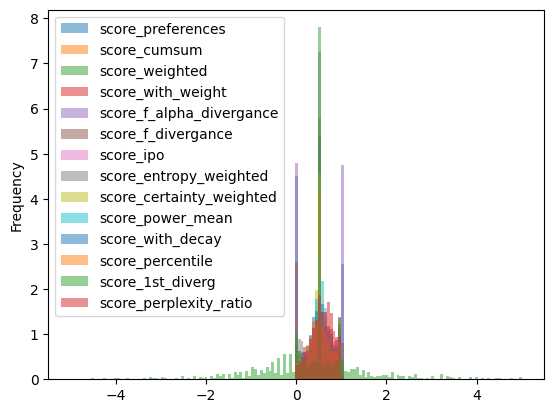

In [18]:
d = df_raw[cols_score].copy()
# d -= d.min()
# d /= d.abs().max()
d.plot.hist(bins=155, range=[-5, 5], alpha=0.5, legend=True, density=True, style="stepped")
d.describe()


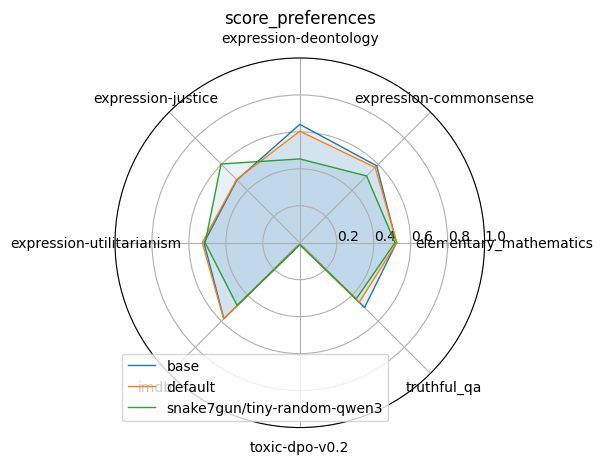

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.523432,0.525055,0.515089
expression-commonsense,0.588689,0.576724,0.511288
expression-deontology,0.640653,0.603630,0.453613
expression-justice,0.481116,0.484158,0.602788
expression-utilitarianism,0.518384,0.528032,0.512214
imdb,0.581309,0.582852,0.479889
toxic-dpo-v0.2,0.010000,0.010000,0.010000
truthful_qa,0.495490,0.454958,0.430854


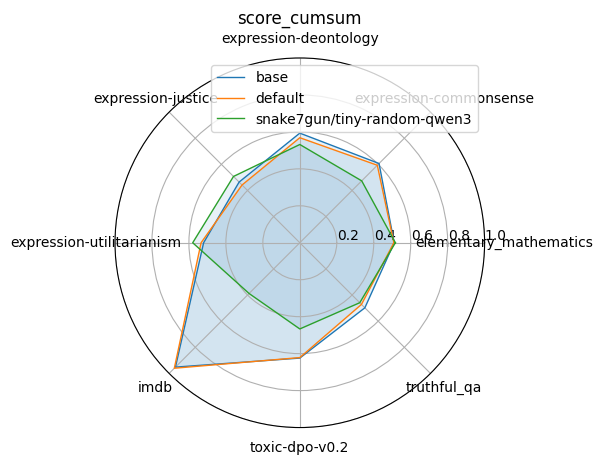

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.510605,0.508999,0.517179
expression-commonsense,0.606461,0.593110,0.473702
expression-deontology,0.593237,0.568407,0.531722
expression-justice,0.464473,0.442067,0.507423
expression-utilitarianism,0.520498,0.534195,0.579545
imdb,0.951714,0.960286,0.388274
toxic-dpo-v0.2,0.624103,0.621393,0.466418
truthful_qa,0.497827,0.471854,0.458808


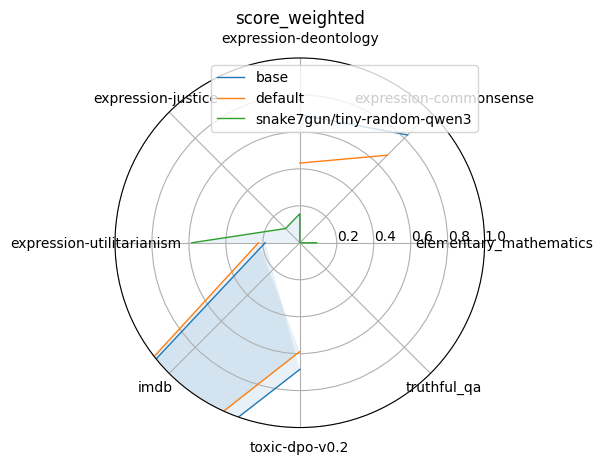

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,-0.204545,-0.190341,0.090909
expression-commonsense,0.824728,0.669837,0.000000
expression-deontology,0.692602,0.431122,0.156888
expression-justice,-0.276786,-0.337500,0.108929
expression-utilitarianism,0.187500,0.223633,0.583984
imdb,4.333333,3.840278,-0.701389
toxic-dpo-v0.2,0.685587,0.588648,-0.104592
truthful_qa,-0.040323,-0.155242,-0.187500


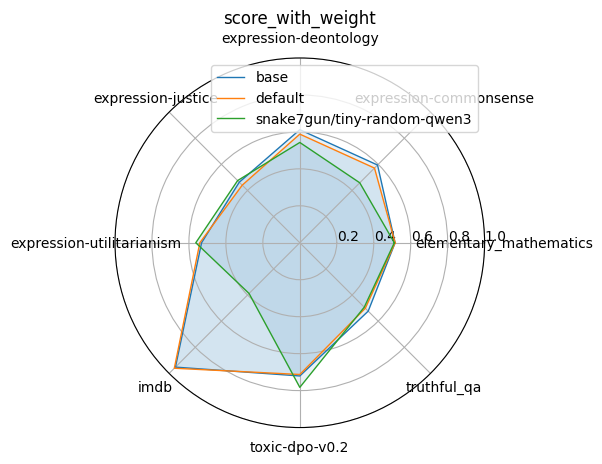

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.515737,0.515881,0.511408
expression-commonsense,0.594855,0.571496,0.458856
expression-deontology,0.611801,0.587801,0.542665
expression-justice,0.463325,0.440633,0.475877
expression-utilitarianism,0.531551,0.540932,0.562847
imdb,0.951714,0.960286,0.388274
toxic-dpo-v0.2,0.720823,0.712851,0.782461
truthful_qa,0.523436,0.501355,0.493212


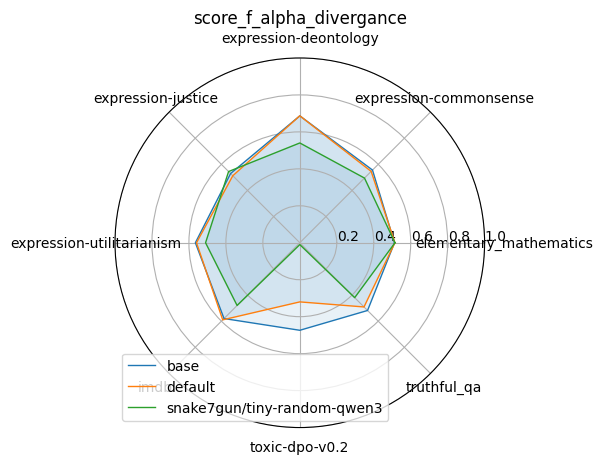

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.512354,0.514711,0.515
expression-commonsense,0.556287,0.546122,0.495
expression-deontology,0.686691,0.686977,0.540
expression-justice,0.529721,0.512898,0.545
expression-utilitarianism,0.565051,0.558981,0.510
imdb,0.580000,0.590000,0.480
toxic-dpo-v0.2,0.473648,0.319999,0.010
truthful_qa,0.518408,0.491236,0.420


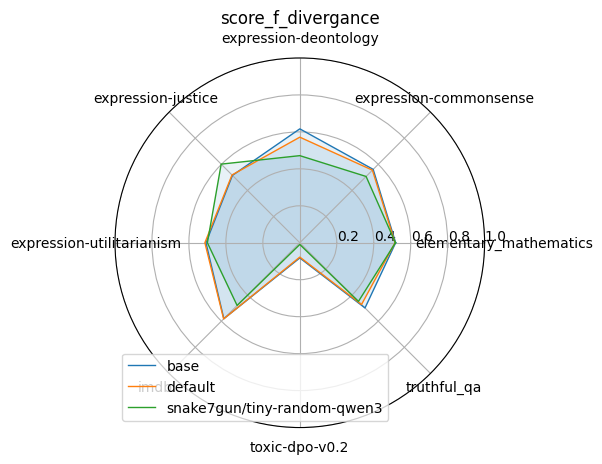

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.518714,0.515463,0.517454
expression-commonsense,0.561517,0.555671,0.507293
expression-deontology,0.616354,0.571366,0.471377
expression-justice,0.515589,0.518825,0.601723
expression-utilitarianism,0.507777,0.513711,0.500107
imdb,0.581322,0.582926,0.479917
toxic-dpo-v0.2,0.082232,0.077595,0.009281
truthful_qa,0.498919,0.472387,0.448754


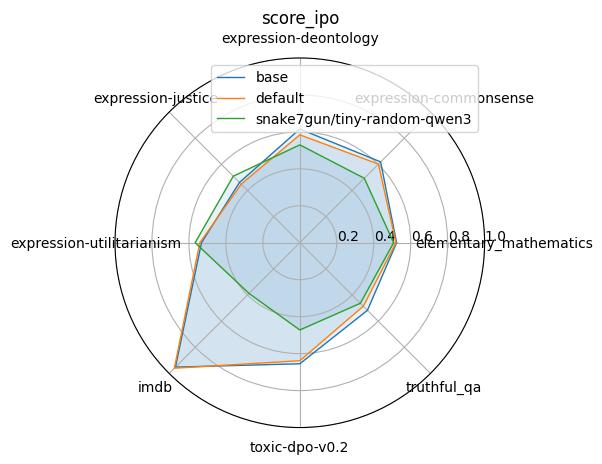

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.523731,0.520374,0.507679
expression-commonsense,0.618647,0.601764,0.493602
expression-deontology,0.615538,0.584019,0.529728
expression-justice,0.461623,0.448348,0.509324
expression-utilitarianism,0.532043,0.541088,0.566437
imdb,0.951714,0.960286,0.388274
toxic-dpo-v0.2,0.654895,0.638293,0.472048
truthful_qa,0.517286,0.485927,0.463373


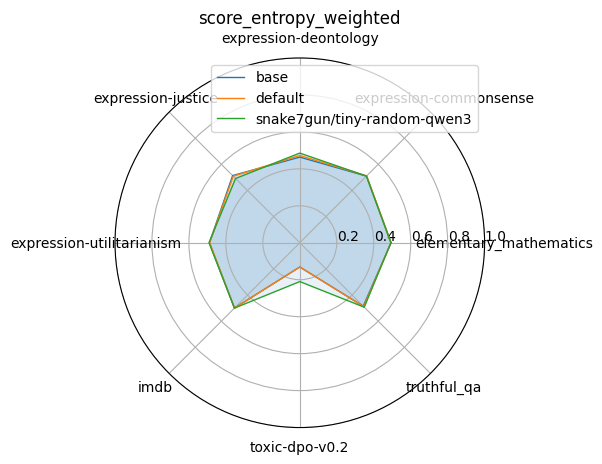

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.494229,0.493477,0.492549
expression-commonsense,0.509873,0.512012,0.510146
expression-deontology,0.463525,0.472251,0.485249
expression-justice,0.514126,0.509297,0.491768
expression-utilitarianism,0.488838,0.487812,0.491514
imdb,0.500039,0.500000,0.500215
toxic-dpo-v0.2,0.131196,0.131345,0.210110
truthful_qa,0.485244,0.488594,0.493308


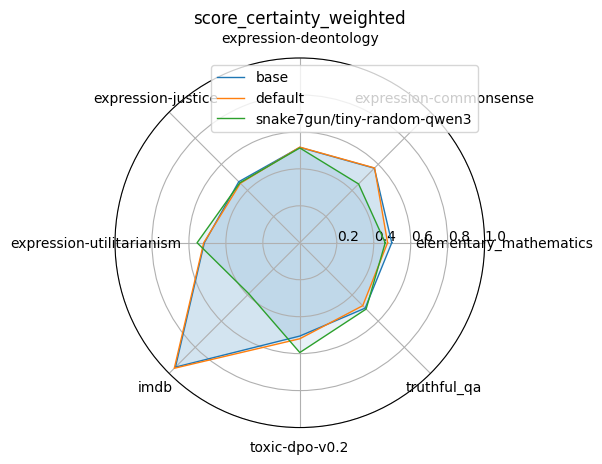

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.497615,0.475067,0.462264
expression-commonsense,0.570716,0.572266,0.449871
expression-deontology,0.516078,0.517498,0.513073
expression-justice,0.467114,0.455101,0.458837
expression-utilitarianism,0.516548,0.519981,0.555878
imdb,0.951714,0.960503,0.390206
toxic-dpo-v0.2,0.504823,0.519551,0.594096
truthful_qa,0.500343,0.481674,0.507499


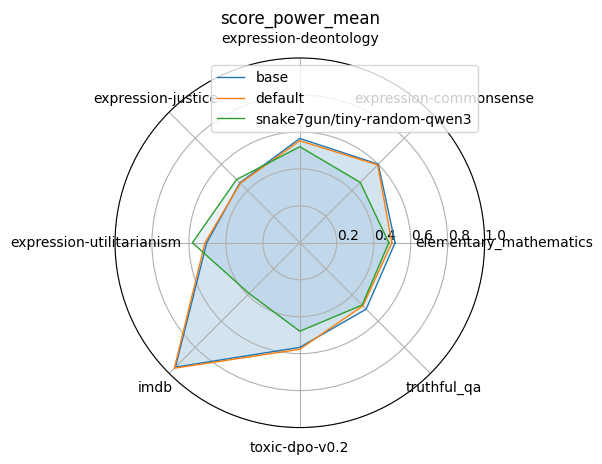

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.515666,0.498186,0.481578
expression-commonsense,0.600671,0.595661,0.462352
expression-deontology,0.564603,0.552306,0.519774
expression-justice,0.458804,0.455428,0.483899
expression-utilitarianism,0.503738,0.513260,0.581421
imdb,0.951714,0.960286,0.388274
toxic-dpo-v0.2,0.566047,0.576072,0.478805
truthful_qa,0.507939,0.482599,0.477027


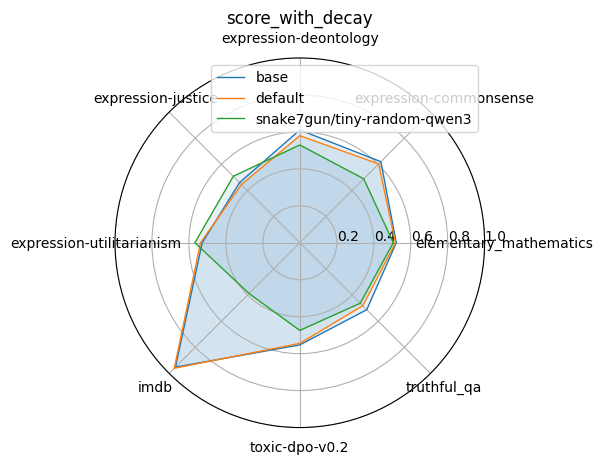

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.522017,0.517794,0.505796
expression-commonsense,0.620296,0.603256,0.489374
expression-deontology,0.610223,0.579519,0.529238
expression-justice,0.460669,0.445944,0.508733
expression-utilitarianism,0.528207,0.537590,0.567761
imdb,0.951791,0.960698,0.388430
toxic-dpo-v0.2,0.552830,0.544553,0.474451
truthful_qa,0.512358,0.481936,0.462726


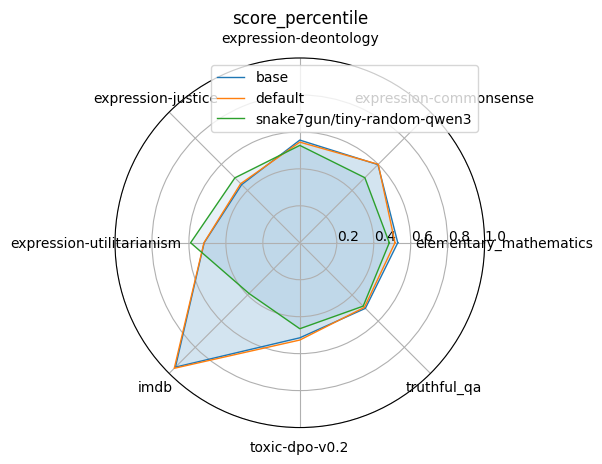

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.530130,0.515154,0.484235
expression-commonsense,0.597953,0.600370,0.497819
expression-deontology,0.555579,0.544569,0.526892
expression-justice,0.444928,0.452271,0.496795
expression-utilitarianism,0.517573,0.518616,0.590944
imdb,0.951791,0.960698,0.388430
toxic-dpo-v0.2,0.514376,0.526495,0.465266
truthful_qa,0.501918,0.494463,0.485008


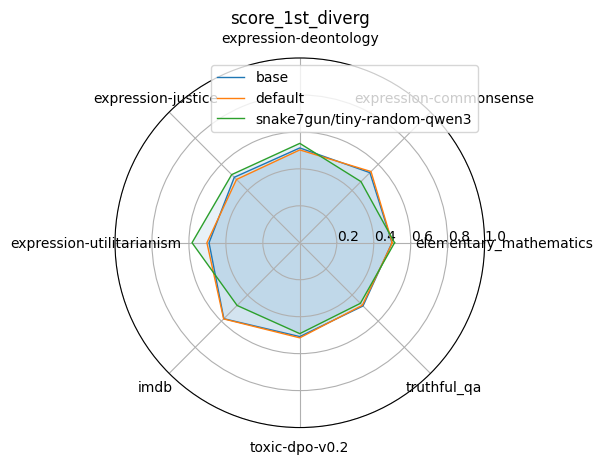

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.498726,0.500283,0.512793
expression-commonsense,0.536455,0.544919,0.467994
expression-deontology,0.513097,0.502396,0.537873
expression-justice,0.501285,0.484389,0.521387
expression-utilitarianism,0.491166,0.502750,0.583213
imdb,0.581309,0.582852,0.479889
toxic-dpo-v0.2,0.507796,0.514542,0.491810
truthful_qa,0.483693,0.478582,0.463550


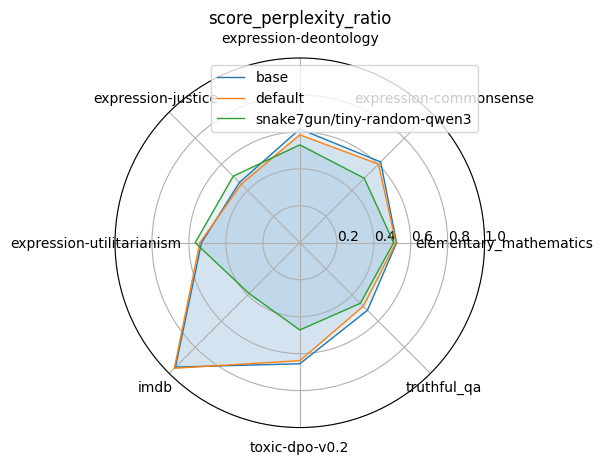

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.523731,0.520286,0.507679
expression-commonsense,0.618647,0.601679,0.493602
expression-deontology,0.615558,0.583979,0.529728
expression-justice,0.461682,0.448404,0.509324
expression-utilitarianism,0.531982,0.541027,0.566437
imdb,0.951714,0.960286,0.388274
toxic-dpo-v0.2,0.654895,0.638293,0.472048
truthful_qa,0.517223,0.485769,0.463373


In [19]:
# what if we apply sigmoid before mean?

df_raw2 = df_raw2a.copy()
# df_raw2[cols_score] = df_raw2[cols_score] > 0.5 # it's in log, so which is prefered
# df_raw2[cols_score] = df_raw2[cols_score].apply(sigmoid)

for c in cols_score:
    df_agg =  df_raw2.groupby(['dataset', 'adapter'], dropna=False)[c].mean().unstack()
    radar_plot(df_agg)
    plt.title(c)
    plt.show()
    display(df_agg)
    
    # df_raw2['prob2'] = df_raw2[c] * df_raw2['norm_policy_weights']
    # df_agg =  df_raw2.groupby(['dataset', 'adapter'], dropna=False)['prob2'].mean().unstack()
    # # df_agg = df_agg.apply(sigmoid)
    # radar_plot(df_agg)
    # plt.title(c + '_norm')
    # plt.show()

In [20]:
# # what if we apply sigmoid before mean?
# cols_score = [c for c in df_raw.columns if c.startswith('score_')]
# df_raw2 = df_raw.copy()
# # df_raw2[cols_score] = df_raw2[cols_score].apply(sigmoid) # it's in log, so which is prefered

# for c in cols_score:
#     df_agg =  df_raw2.groupby(['dataset', 'adapter'], dropna=False)[c].mean().unstack()
#     df_agg = df_agg.apply(sigmoid)
#     radar_plot(df_agg)
#     plt.title(c)
#     plt.show()
    
#     # df_raw2['prob2'] = df_raw2[c] * df_raw2['norm_policy_weights']
#     # df_agg =  df_raw2.groupby(['dataset', 'adapter'], dropna=False)['prob2'].mean().unstack()
#     # # df_agg = df_agg.apply(sigmoid)
#     # radar_plot(df_agg)
#     # plt.title(c + '_norm')
#     # plt.show()

In [21]:
# df_agg =  df_raw.groupby(['dataset', 'adapter'], dropna=False)['prob'].mean().unstack()

# radar_plot(df_agg)
# df_agg

In [22]:
# df_raw_bool.pivot(index='adapter', columns='dataset', values=c)
import pandas as pd


In [23]:
# df_agg =  df_raw.groupby(['dataset'], dropna=False)['prob'].mean().to_frame()#.unstack()

# radar_plot(df_agg)
# df_agg

In [24]:
def evaluate_scoring_method(scores_df, method_name):
    # Pivot for easier analysis
    scores_df = scores_df.copy()
    scores_df[method_name] = scores_df[method_name].replace([np.inf, -np.inf], np.nan)
    scores = pd.pivot_table(scores_df, index='adapter', columns='dataset', values=method_name, aggfunc='mean')
    scores = scores.clip(lower=0, upper=1)  # Clip scores to [0, 1] range
    # print(scores)
    
    # 1. IMDB should be high (most models > 0.8)
    imdb_score = scores['imdb'].mean()
    
    # 2. Hard datasets should be low (if you have a hard_math dataset)
    hard_math_score = scores['elementary_mathematics'].mean()# if 'elementary_mathematics' in scores else 0.5
    hard_math_penalty = 1 - abs(hard_math_score - 0.5)

    # 3. Random model should be ~0.5
    random_model = 'snake7gun/tiny-random-qwen3'  # your random model
    random_deviation = abs(scores.loc[random_model].mean() - 0.5)
    random_penalty = 1 - random_deviation  # 1 is good, 0 is bad
    
    # 4. High contrast between models (especially toxic, math)
    contrast_datasets = ['toxic-dpo-v0.2', 'elementary_mathematics', 'expression-justice']
    contrasts = [scores[ds].std() for ds in contrast_datasets if ds in scores]
    avg_contrast = np.mean(contrasts)

    # 3. Discrimination - use robust measure
    contrast_datasets = ['toxic-dpo-v0.2', 'elementary_mathematics', 'expression-justice']
    contrasts = []
    for ds in contrast_datasets:
        if ds in scores and not scores[ds].isna().all():
            # Use IQR instead of std - more robust to outliers
            q75, q25 = scores[ds].quantile(0.75), scores[ds].quantile(0.25)
            iqr = q75 - q25
            # Normalize by median to make it scale-invariant
            median = scores[ds].median()
            if median > 0:
                contrasts.append(min(iqr / median, 2))  # cap at 2
    
    avg_contrast = np.mean(contrasts) if contrasts else 0
    
    # 5. Bonus: censored vs uncensored should differ on toxic
    if 'toxic-dpo-v0.2' in scores:
        # Assuming censored models score low, uncensored high
        toxic_spread = scores['toxic-dpo-v0.2'].max() - scores['toxic-dpo-v0.2'].min()
    else:
        toxic_spread = 0
    
    # Combined score
    quality = (
        imdb_score * 2 +              # weight easy dataset performance
        random_penalty * 3 +          # important: random = 0.5
        avg_contrast * 2 +            # discrimination power
        toxic_spread +                 # specific contrast we expect
        hard_math_penalty               # weight hard dataset performance
    ) / 10  # normalize to [0, 1]

    return {
        'overall': quality,
        'imdb_mean': imdb_score,
        'random_calibration': random_penalty,
        'discrimination': avg_contrast,
        'toxic_spread': toxic_spread,
        'hard_math': hard_math_score,

    }

In [25]:
df_raw[cols_score].describe()

,score_preferences,score_cumsum,score_weighted,score_with_weight,score_f_alpha_divergance,score_f_divergance,score_ipo,score_entropy_weighted,score_certainty_weighted,score_power_mean,score_with_decay,score_percentile,score_1st_diverg,score_perplexity_ratio
count,2400.000000,1434.000000,1434.000000,1.434000e+03,2400.000000,2400.000000,1434.000000,2400.000000,1.434000e+03,1.434000e+03,1434.000000,1434.000000,2.400000e+03,1434.000000
mean,0.463342,0.542564,0.307706,5.811718e-01,0.506587,0.467761,0.552345,0.452363,5.212015e-01,5.306878e-01,0.537428,0.525594,5.117812e-01,0.552331
std,0.371623,0.257145,1.675245,2.685664e-01,0.399700,0.311893,0.246423,0.179127,2.173245e-01,2.128666e-01,0.246285,0.223172,2.621150e-01,0.246419
min,0.000000,0.000123,-8.750000,4.602043e-10,0.000000,0.000000,0.000179,0.012451,6.007031e-08,2.384186e-07,0.000212,0.000003,1.722947e-08,0.000179
25%,0.001066,0.371094,-0.437500,4.003906e-01,0.000000,0.206182,0.392578,0.386719,4.257812e-01,4.101562e-01,0.373885,0.396141,4.863281e-01,0.392578
50%,0.500000,0.544922,0.250000,6.210938e-01,0.500000,0.500000,0.562500,0.500000,5.078125e-01,5.312500e-01,0.535230,0.508343,5.000000e-01,0.562500
75%,0.798828,0.726562,1.000000,7.890625e-01,1.000000,0.598312,0.729492,0.500000,6.093750e-01,6.513672e-01,0.717232,0.655060,5.517578e-01,0.729492
max,1.000000,1.000000,10.500000,1.000000e+00,1.000000,1.000000,1.000000,0.968750,1.000000e+00,1.000000e+00,0.999985,0.999976,1.000000e+00,1.000000


In [26]:
# scores = pd.pivot_table(df_raw, index='adapter', columns='dataset', values=cols_score, aggfunc='mean')
# scores.describe()

In [27]:

df_raw_bool = df_raw.copy()
cols_score = [c for c in df_raw_bool.columns if c.startswith('score_')]#+['correct']
df_raw_bool[cols_score] = df_raw_bool[cols_score] > 0.5 # it's in log, so which is prefered
df_raw_bool['dataset'] = df_raw_bool['dataset'].apply(rename_ds)

df_raw2 = df_raw.copy()
# df_raw2[cols_score] = df_raw2[cols_score] > 0.5 # it's in log, so which is prefered
df_raw2['dataset'] = df_raw2['dataset'].apply(rename_ds)    


res = {}
for c in cols_score:
    v = evaluate_scoring_method(df_raw_bool, c)
    v2 = evaluate_scoring_method(df_raw2, c)
    print(f"{v['overall']:.2f} {c} [bool]")
    print(f"{v2['overall']:.2f} {c}")
    res[c+'_bool'] = v
    res[c] = v2



0.34 score_preferences [bool]
0.50 score_preferences
0.39 score_cumsum [bool]
0.58 score_cumsum
0.39 score_weighted [bool]
0.56 score_weighted
0.36 score_with_weight [bool]
0.56 score_with_weight
0.42 score_f_alpha_divergance [bool]
0.59 score_f_alpha_divergance
0.34 score_f_divergance [bool]
0.53 score_f_divergance
0.41 score_ipo [bool]
0.58 score_ipo
0.31 score_entropy_weighted [bool]
0.52 score_entropy_weighted
0.39 score_certainty_weighted [bool]
0.57 score_certainty_weighted
0.40 score_power_mean [bool]
0.57 score_power_mean
0.38 score_with_decay [bool]
0.57 score_with_decay
0.42 score_percentile [bool]
0.57 score_percentile
0.34 score_1st_diverg [bool]
0.51 score_1st_diverg
0.41 score_perplexity_ratio [bool]
0.58 score_perplexity_ratio


In [28]:
res2 = pd.DataFrame(res).T.sort_values('discrimination', ascending=False)
res2

,overall,imdb_mean,random_calibration,discrimination,toxic_spread,hard_math
score_weighted,0.556667,0.666667,0.617589,0.582340,6.855868e-01,0.030303
score_f_alpha_divergance_bool,0.421195,0.140000,0.770000,0.264309,4.600000e-01,0.133333
score_f_alpha_divergance,0.587263,0.550000,0.939375,0.252441,4.636477e-01,0.514022
score_weighted_bool,0.386237,0.136667,0.656250,0.246808,5.600000e-01,0.066667
score_percentile_bool,0.420677,0.140000,0.785000,0.245884,4.700000e-01,0.110000
score_f_divergance,0.534863,0.548055,0.941988,0.185410,7.295125e-02,0.517211
score_power_mean_bool,0.404497,0.140000,0.770000,0.180817,4.900000e-01,0.103333
score_certainty_weighted_bool,0.389990,0.140000,0.793750,0.175991,2.900000e-01,0.096667
score_ipo_bool,0.409460,0.140000,0.777500,0.172715,5.300000e-01,0.106667
score_perplexity_ratio_bool,0.409460,0.140000,0.777500,0.172715,5.300000e-01,0.106667
